In [ ]:
#Importing Required Libraries
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torch.nn as nn

In [ ]:
#Check GPU availability
print(torch.cuda.is_available())
print(torch.cuda.device_count())

True
1


In [ ]:
#Define pre-processing for the dataset
data_statistics = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
train_transforms_cifar = transforms.Compose([
    transforms.RandomCrop(32, padding = 1, padding_mode = "reflect"),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(*data_statistics, inplace = True)
])

test_transforms_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(*data_statistics, inplace = True)
])

dataset = torchvision.datasets.CIFAR10(root = "data/", download = True, transform = train_transforms_cifar)
test_dataset = torchvision.datasets.CIFAR10(root = "data/", download = True, train = False, transform = test_transforms_cifar)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
#Define training, validation & testing dataset
val_ratio = 0.2
train_dataset, val_dataset = random_split(dataset, [int((1 - val_ratio) * len(dataset)), int(val_ratio * len(dataset))])
batch_size = 32
train_dl = DataLoader(train_dataset, batch_size, shuffle = True, pin_memory = True)
val_dl = DataLoader(val_dataset, batch_size, shuffle = True, pin_memory = True)
test_dl = DataLoader(test_dataset, batch_size, pin_memory = True)

In [ ]:
#Visualize the dataset
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return (images * stds) + means

def show_preview(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize = (5, 5))
        images = denormalize(images, *data_statistics)
        ax.imshow(make_grid(images, 5).permute(1, 2, 0))
        #print(images.shape, labels)
        break

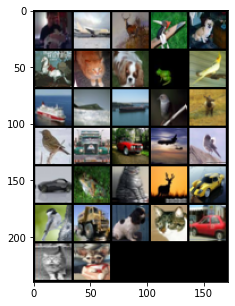

In [ ]:
show_preview(train_dl)

In [ ]:
#CUDA specific code
def get_default_device():
    return torch.device("cuda") if torch.cuda.is_available() is True else torch.device("cpu")

def to_device(entity, device):
    if isinstance(entity, (list, tuple)):
        return [to_device(element, device) for element in entity]
    return entity.to(device, non_blocking = True)

class DeviceDataLoader():
    def __init__(self, dataloader, device):
        self.dl = dataloader
        self.device = device
    
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
    
    def __len__(self):
        return len(self.dl)


device = get_default_device()
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

In [ ]:
print("Default device: ", device)

Default device:  cuda


In [ ]:
#Define the underlying conv block
def conv_block(in_channels, out_channels, pooling = False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1),
    nn.BatchNorm2d(out_channels),
    nn.ReLU(inplace = True)]
    
    if pooling:
        layers.append(nn.MaxPool2d(2))
    
    return nn.Sequential(*layers)

In [ ]:
#Define the custom ResNetX model
class ResNetX(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pooling = True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

        self.conv3 = conv_block(128, 256, pooling = True)
        self.conv4 = conv_block(256, 512, pooling = True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                        nn.Flatten(),
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
  
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        return self.classifier(out)

In [ ]:
#Define the evaluation metrics
def accuracy(logits, labels):
    pred, predClassId = torch.max(logits, dim = 1)
    return torch.tensor(torch.sum(predClassId == labels).item() / len(logits))

def evaluate(model, dl, loss_func):
  model.eval()
  batch_losses, batch_accs = [], []
  for images, labels in dl:
      with torch.no_grad():
          logits = model(images)
      batch_losses.append(loss_func(logits, labels))
      batch_accs.append(accuracy(logits, labels))
  epoch_avg_loss = torch.stack(batch_losses).mean().item()
  epoch_avg_acc = torch.stack(batch_accs).mean().item()
  return epoch_avg_loss, epoch_avg_acc

In [ ]:
#Define training method
def train(model, train_dl, val_dl, epochs, max_lr, loss_func, optim):
    optimizer = optim(model.parameters(), max_lr)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs * len(train_dl))
    
    results = []
    
    for epoch in range(epochs):
        model.train()
        train_losses = []
        lrs = []
        for images, labels in train_dl:
            logits = model(images)
            loss = loss_func(logits, labels)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            lrs.append(optimizer.param_groups[0]["lr"])
            scheduler.step()
        epoch_train_loss = torch.stack(train_losses).mean().item()
        
        epoch_avg_loss, epoch_avg_acc = evaluate(model, val_dl, loss_func)
        print("Epoch: ", epoch, " Avg_valid_loss: ", epoch_avg_loss, " Avg_valid_acc: ", epoch_avg_acc, " Avg_train_loss: ", epoch_train_loss)
        results.append({"avg_valid_loss": epoch_avg_loss, "avg_valid_acc": epoch_avg_acc, "avg_train_loss": epoch_train_loss})

    return results

In [ ]:
#Define the model parameters
model = ResNetX(3, 10)
model = to_device(model, device)
epochs = 15
max_lr = 1e-2
loss_func = nn.functional.cross_entropy
optim = torch.optim.Adam

In [ ]:
#Training the model
%%time
results = train(model, train_dl, val_dl, epochs, max_lr, loss_func, optim)

Epoch:  0  Avg_valid_loss:  1.023026466369629  Avg_valid_acc:  tensor(0.6596)  Avg_train_loss:  1.3427979946136475
Epoch:  1  Avg_valid_loss:  0.9439870715141296  Avg_valid_acc:  tensor(0.6795)  Avg_train_loss:  1.0420140027999878
Epoch:  2  Avg_valid_loss:  0.7461492419242859  Avg_valid_acc:  tensor(0.7452)  Avg_train_loss:  0.790636420249939
Epoch:  3  Avg_valid_loss:  0.6316223740577698  Avg_valid_acc:  tensor(0.7851)  Avg_train_loss:  0.7045962810516357
Epoch:  4  Avg_valid_loss:  0.8040247559547424  Avg_valid_acc:  tensor(0.7401)  Avg_train_loss:  0.6483649015426636
Epoch:  5  Avg_valid_loss:  0.634896457195282  Avg_valid_acc:  tensor(0.7788)  Avg_train_loss:  0.5900716185569763
Epoch:  6  Avg_valid_loss:  0.5290087461471558  Avg_valid_acc:  tensor(0.8229)  Avg_train_loss:  0.5290735363960266
Epoch:  7  Avg_valid_loss:  0.46487221121788025  Avg_valid_acc:  tensor(0.8457)  Avg_train_loss:  0.47646424174308777
Epoch:  8  Avg_valid_loss:  0.4242505729198456  Avg_valid_acc:  tensor(0.

In [ ]:
results

[{'avg_train_loss': 1.3427979946136475,
  'avg_valid_acc': tensor(0.6596),
  'avg_valid_loss': 1.023026466369629},
 {'avg_train_loss': 1.0420140027999878,
  'avg_valid_acc': tensor(0.6795),
  'avg_valid_loss': 0.9439870715141296},
 {'avg_train_loss': 0.790636420249939,
  'avg_valid_acc': tensor(0.7452),
  'avg_valid_loss': 0.7461492419242859},
 {'avg_train_loss': 0.7045962810516357,
  'avg_valid_acc': tensor(0.7851),
  'avg_valid_loss': 0.6316223740577698},
 {'avg_train_loss': 0.6483649015426636,
  'avg_valid_acc': tensor(0.7401),
  'avg_valid_loss': 0.8040247559547424},
 {'avg_train_loss': 0.5900716185569763,
  'avg_valid_acc': tensor(0.7788),
  'avg_valid_loss': 0.634896457195282},
 {'avg_train_loss': 0.5290735363960266,
  'avg_valid_acc': tensor(0.8229),
  'avg_valid_loss': 0.5290087461471558},
 {'avg_train_loss': 0.47646424174308777,
  'avg_valid_acc': tensor(0.8457),
  'avg_valid_loss': 0.46487221121788025},
 {'avg_train_loss': 0.4056302011013031,
  'avg_valid_acc': tensor(0.8605)

In [ ]:
for result in results:
  print(result["avg_train_loss"])

1.3595210313796997
1.0484095811843872
0.7817363142967224
0.6925605535507202
0.6397367119789124
0.5832736492156982
0.5326931476593018
0.47313210368156433
0.4037984311580658
0.3310961425304413
0.2609929144382477
0.19635124504566193
0.14713077247142792
0.11456603556871414
0.10393249243497849


In [ ]:
#Evaluate the model on testing data
_, test_acc = evaluate(model, test_dl, loss_func)
print(test_acc)

tensor(0.9097)


In [ ]:
#Saving the model and then loading the model for verification
torch.save(model.state_dict(), "cifar-10-ResNetX.pth")
model_2 = ResNetX(3, 10)
model_2 = to_device(model_2, device)
_, test_acc_model_2 = evaluate(model_2, test_dl, loss_func)
print(test_acc_model_2 )
model_2.load_state_dict(torch.load("cifar-10-ResNetX.pth"))
_, test_acc_model_2_after_loading = evaluate(model_2, test_dl, loss_func)
print(test_acc_model_2_after_loading )

tensor(0.0857)
tensor(0.9097)


In [ ]:
def plot(results, pairs):
  fig, axes = plt.subplots(len(pairs), figsize = (10, 10))
  for i, pair in enumerate(pairs):
    for title, graphs in pair.items():
      for graph in graphs:
        axes[i].set_title(title)
        axes[i].plot([result[graph] for result in results], "r")

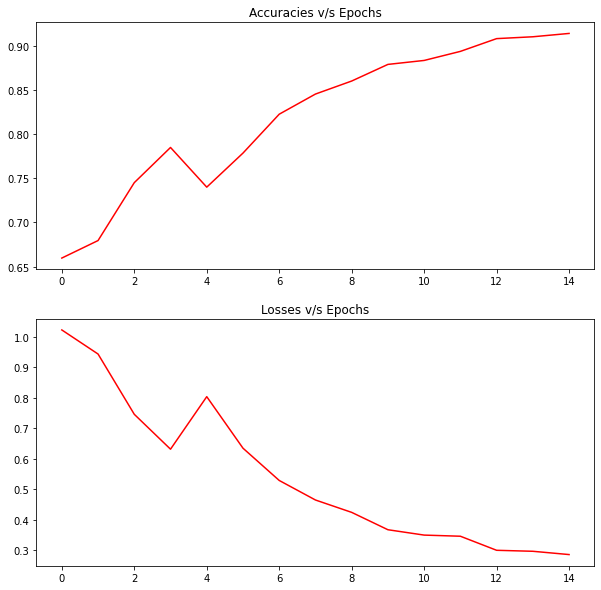

In [ ]:
plot(results, [{"Accuracies v/s Epochs": ["avg_valid_acc"]}, {"Losses v/s Epochs": ["avg_valid_loss"]}])

References:
1. https://www.analyticsvidhya.com/blog/2021/06/build-resnet-from-scratch-with-python/
2. https://towardsdev.com/implement-resnet-with-pytorch-a9fb40a77448
3. https://www.youtube.com/watch?v=GNX2m1ZREtA
4. https://towardsdatascience.com/residual-network-implementing-resnet-a7da63c7b278